In [1]:
import pandas as pd
import numpy as np

# Word Embeddings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
print(f'gensim: {gensim.__version__}')

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout, MaxPooling2D

# Text
from nltk.tokenize import word_tokenize 
from nltk.tokenize import TweetTokenizer
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

# Storing as objects via serialization
from tempfile import mkdtemp
import pickle
import joblib

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

# Directory
import os
import yaml
import collections
import scattertext as st
import math

import nltk
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

nltk.download('punkt')

# Cool progress bars
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()  # Enable tracking of execution progress

chat_bot_dir_path = '/Users/alizafar/Documents/MEST/Deep Learning/Final Project/'

gensim: 4.1.2


[nltk_data] Downloading package punkt to /Users/alizafar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/var/folders/kc/s37qcz1d1_38tm37v5dm7gnm0000gn/T/ipykernel_4148/3581903901.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()  # Enable tracking of execution progress


0it [00:00, ?it/s]

In [2]:
# Temp: Remove params from sep='/t'
# joining data oaths, dekimiting the file, 
df = pd.read_csv(chat_bot_dir_path + 'data.csv',sep='\t', error_bad_lines=False, encoding= 'unicode_escape')
df = df.drop(columns=["ArticleFile"], axis=1)

# Changing python columns name as per python convention
df = df.rename(columns={"ArticleTitle": "article_title", "Question": "question", "Answer": "answer"})

# Drop the nan/ blank row data
df = df.drop(df.columns[[3, 4]], axis=1)
df = df.dropna()

print("Shape of data: ", df.shape)
df.head()

Shape of data:  (1473, 3)


/Users/alizafar/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 1689: expected 6 fields, saw 7\n'


,article_title,question,answer
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.
4,Abraham_Lincoln,Did his mother die of pneumonia?,no


Actual data's Count List
range(0, 35)


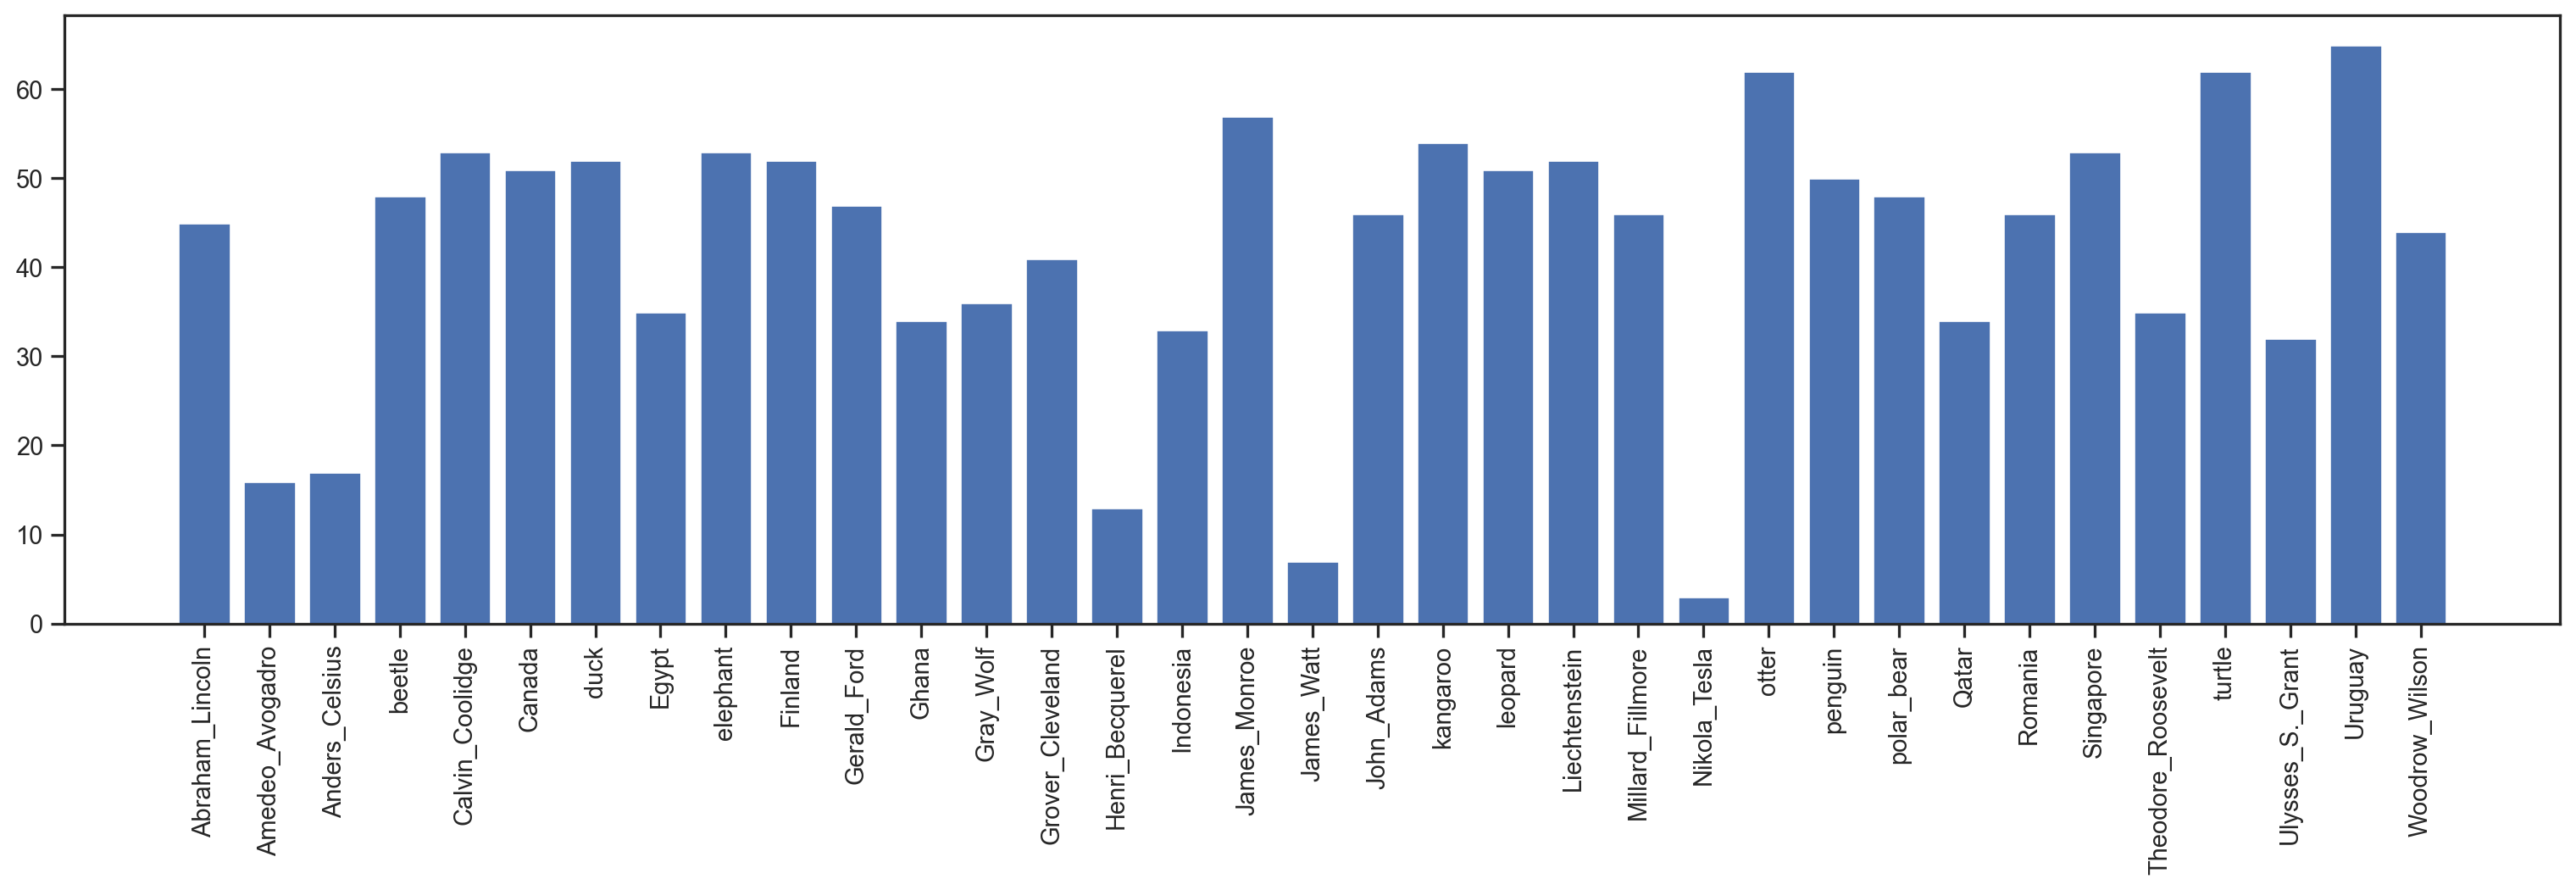

In [3]:
# Plotting the data based on the article_title

def get_article_title_count(df):
  article_titles = df.article_title.unique()
  # article_titles = article_titles[:5]
  article_title_count = {}
  for article_title in article_titles:
    count =  df[df.article_title == article_title].shape[0]
    article_title_count[article_title] = count
  
  plt.figure(figsize=(20, 5), dpi=190)
  print(range(len(article_title_count)))
  plt.bar(range(len(article_title_count)), list(article_title_count.values()), align='center')
  plt.xticks(range(len(article_title_count)), list(article_title_count.keys()))
  plt.xticks(rotation=90)
  plt.plot()

print("Actual data's Count List")
get_article_title_count(df)

In [4]:
# Tokenization only Question & Answer columns
punctuation_regex = '[^\w\s]'
df['tokenized_qustions'] = df['question'].str.replace(punctuation_regex,'').apply(wordpunct_tokenize)
df['tokenized_answer'] = df['answer'].str.replace(punctuation_regex,'').apply(wordpunct_tokenize)

/var/folders/kc/s37qcz1d1_38tm37v5dm7gnm0000gn/T/ipykernel_4148/1420661997.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tokenized_qustions'] = df['question'].str.replace(punctuation_regex,'').apply(wordpunct_tokenize)
/var/folders/kc/s37qcz1d1_38tm37v5dm7gnm0000gn/T/ipykernel_4148/1420661997.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tokenized_answer'] = df['answer'].str.replace(punctuation_regex,'').apply(wordpunct_tokenize)


In [5]:
df.head()

,article_title,question,answer,tokenized_qustions,tokenized_answer
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,"[Was, Abraham, Lincoln, the, sixteenth, Presid...",[yes]
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,"[Was, Abraham, Lincoln, the, sixteenth, Presid...",[Yes]
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,"[Did, Lincoln, sign, the, National, Banking, A...",[yes]
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,"[Did, Lincoln, sign, the, National, Banking, A...",[Yes]
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,"[Did, his, mother, die, of, pneumonia]",[no]


In [6]:
model = None
def train_doc2vec(string_data, max_epochs, vec_size, alpha):
    global model
    # Tagging each of the data with an ID, and I use the most memory efficient one of just using it's ID
    tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) 
                   for i, _d in enumerate(string_data)]
    
    model = Doc2Vec(vector_size=vec_size, window=2, min_count=1, workers=4)

    model.build_vocab(tagged_data)

    for epoch in range(max_epochs):
        print('iteration {0}'.format(epoch))
        model.train(tagged_data, total_examples = model.corpus_count, epochs=100)
        # Decrease the learning rate
        model.alpha -= 0.0002
        # Fix the learning rate, no decay
        model.min_alpha = model.alpha

    # Saving model
    model.save(chat_bot_dir_path + "models/answer_d2v.model")
    print("Model Saved")


df['tokenized_qustions'].head()


tokenized_question = df['tokenized_qustions'].progress_apply(" ".join)

  0%|          | 0/1473 [00:00<?, ?it/s]

In [7]:
train_doc2vec(tokenized_question, max_epochs = 10, vec_size = 20, alpha = 0.025)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Model Saved


In [10]:
import random

# testing_question = 'Where did Lincoln born'
vector = model.infer_vector(["Where", "did", "Lincoln", "born"]) 
print(vector)

testing_question = ['Did', 'John' , 'go' , 'to' , 'Haravard']

for match in

# doc_id = random.randint(0, len(df['tokenized_qustions']) - 1)
# inferred_vector = model.infer_vector(df['tokenized_qustions'][doc_id])
inferred_vector = model.infer_vector(testing_question)
sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))

[-0.23340562  0.49568832  0.85195076  0.75930434 -0.5844833  -0.5184244
 -0.38241413  0.49273482  0.05411904 -0.4639125   1.0739452  -0.77907425
  0.36547503 -0.15515415  0.4235221  -0.72609043  0.75405693 -0.75097877
 -0.26357347 -0.90756243]


In [9]:
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(df['tokenized_qustions'][doc_id])))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
print('Answer Document ({}): «{}»\n'.format(doc_id, ' '.join(df['tokenized_answer'][doc_id])))
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: ' % (label, sims[index],))

Test Document (1442): «Was Lee Kuan Yew a successful leader of Singapore»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d20,n5,w2,s0.001,t4):

Answer Document (1442): «yes»

MOST ('540', 0.8931265473365784): 
MEDIAN ('1443', 0.4782892167568207): 
LEAST ('240', 0.03720759600400925): 
